# Capstone Project: Stroke Risk Stratification by Classification #

This is a capstone project for Springboard's data science intensive track. The dataset used in this project is sourced from the data science competition sponsor by McKinsey analytics and held in a platform "Analytics Vidhya". 

The competition link can be found here [contest pages] (https://datahack.analyticsvidhya.com/contest/mckinsey-analytics-online-hackathon/).

** Problem Statement: ** a chain of hospitals in US collected annonymized pool of patients data for stroke classification. Stroke is one of critical disease which affects nearly 1 in 20 Americans and is a disease that affects arteries leading to and within the brain. A stroke occurs when a blood vessel that carries oxygen and nutrients to the brain is either blocked by a clot or ruptures. When that happens part of the brain cannot get the blood (and oxygen) it needs, so the brain cells in the affected region is dead. The clients captured several lifestyle, health monitoring measurements and demographic factors about their anonymized patients. These include features like age, gender, health monitoring measurements (i.e., glucose level, body mass index) and life style factors (i.e., smoking status, occupation type etc.). 

** Dataset: **
The data source was contributed by a chain of hospital clients based in US for McKinsey consulting firm. McKinsey hosted this dataset as open data science hack competition on Analytics Vidhya. The dataset consists of 11 features on anonymized patients including mixed variables (i.e., numerical and categorical) such as patient ID, gender, health conditions and other demographic features. The volume of dataset contains about 43,000 patient cases.

** Stakeholders: **
Hospital cardiac unit managers, a group of clinicians, insurance companies and employers from patient population.

** Goal: ** 
To develop a classification model predicts patients at high risks of developing a stroke condition

** Results: **
80% of accurate predictions were made on test set of patient population using Majority Vote classifier.

** Risks: **
Model incorrectly identified with 20% of error (especially 10% of error being Type II error).

** Mitigation: **
Review identifed cases with a group of clinicians before any clinical decision making

** Next Steps for Future Work: **
* Collection of meaningful features.
* Model improvement: algorithms, resampling strategies and classifier designs (i.e., age-specific)

** Recommendations for Clients: **
1. Implement additional stroke screening test at a recommended age (before 65 year-old)
2. Collect meaningful features for building an accurate model: stress level, physical activity, genetic factors, etc.
3. Conduct cohort studies: further study and stratify patient groups into diabetic and obese population based on given average glucose level  and body mass index (BMI) defined by clinical study guidelines.

## Part A. Data Wrangling ##
Dataset required data cleansing and metadata formatting. Dataset was loaded onto Python as a dataframe. Dataset presented with a couple of problems such as missing data, outliers and imbalanced classes. In order to clean our dataset and prepared for classification modeling, data cleaning processes were executed. Processes were performed in a following order: feature imputation --> handling outliers --> format metadata types --> feature transformation (i.e., feature encoding). Once dataset was prepared, data exploration and machine learning model buidling exercises were performed.

In [1]:
# import all libraries:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import operator
from matplotlib.colors import ListedColormap
from itertools import cycle
from sklearn.preprocessing import Imputer
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from scipy.stats import randint
from scipy import interp
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import sklearn.base as skb
from sklearn.externals import six
from sklearn.pipeline import _name_estimators
import sklearn.metrics as skm

# Read train data:
df = pd.read_csv('stroke_train.csv')
# Check dataframe info.:
df.info()

# Print the dataframe head:
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43400 entries, 0 to 43399
Data columns (total 12 columns):
id                   43400 non-null int64
gender               43400 non-null object
age                  43400 non-null float64
hypertension         43400 non-null int64
heart_disease        43400 non-null int64
ever_married         43400 non-null object
work_type            43400 non-null object
Residence_type       43400 non-null object
avg_glucose_level    43400 non-null float64
bmi                  41938 non-null float64
smoking_status       30108 non-null object
stroke               43400 non-null int64
dtypes: float64(3), int64(4), object(5)
memory usage: 4.0+ MB
      id  gender   age  hypertension  heart_disease ever_married  \
0  30669    Male   3.0             0              0           No   
1  30468    Male  58.0             1              0          Yes   
2  16523  Female   8.0             0              0           No   
3  56543  Female  70.0             0      

### Check # of missing value counts and percentage ###

In [2]:
# Check number of missing values:
df.isnull().sum()

# Compute missing value stat.: pre-data cleansing
df_missing = df.isnull().sum()
df_missing = pd.DataFrame(df_missing)
df_missing.columns = ['missing_value_counts']
df_missing['missing_PCT'] = (df_missing['missing_value_counts']/len(df))*100

# sort values by missing percent(%):
df_missing = df_missing.sort_values(by='missing_PCT',ascending=False)
df_missing

,missing_value_counts,missing_PCT
smoking_status,13292,30.626728
bmi,1462,3.368664
id,0,0.000000
gender,0,0.000000
age,0,0.000000
hypertension,0,0.000000
heart_disease,0,0.000000
ever_married,0,0.000000
work_type,0,0.000000
Residence_type,0,0.000000


* Smoking_status is a categorical feature and it was missing 30.6% of observations.
* Followed by BMI is a numerical feature and it was missing about 3.37%.

### Compute Summary Statistics: pre-data cleansing ###
Computer summary statistics and report on numerical features only!

In [3]:
# Compute summary stat.: pre-data cleansing 
df_summary_pre = df.describe().T
# Reorder columns order in summary dataframe:
df_summary_pre = df_summary_pre[['count','min','max','mean','25%','50%','75%','std']]
# Keep only numerical (scale) features:
df_summary_pre = df_summary_pre.drop(['id','heart_disease','hypertension','stroke'])
df_summary_pre

,count,min,max,mean,25%,50%,75%,std
age,43400.0,0.08,82.00,42.217894,24.00,44.00,60.00,22.519649
avg_glucose_level,43400.0,55.00,291.05,104.482750,77.54,91.58,112.07,43.111751
bmi,41938.0,10.10,97.60,28.605038,23.20,27.70,32.90,7.770020


### Handling outliers with inter-quartile range (IQR) method ###
Outliers were required to be managed properly on numerical features. In a training set, there were three independent features (i.e., continuous). These included “age”, “BMI” and “avg_glucose_level”. Interquartile range (IQR) method applied here. For example, if any value of a feature sits below lower and above upper bounds of IQR, these observations will be removed from dataset. 

IQR is defined as: IQR = Q3 – Q1 in which Q3 is 75th percentile and Q1 is 25th percentile of a feature. Lower bound (LB) equals to Q1 – (1.5*IQR) and upper bound (UB) equals to Q3 + (1.5*IQR).

From above definition, summary table was computed on all three numerical features. We can observed that the max. value on each of feature is greater than the upper bound value for average glucose and BMI. Therefore, presence of outliers were confirmed for BMI and average glucose level on beyond upper bound values.

In [4]:
# Handling outliers #
###############################################################################
# Compute IQR, LowerBound and UpperBound: age, bmi, glucose
df_summary_pre['IQR'] = df_summary_pre['75%'] - df_summary_pre['25%']
df_summary_pre['LB'] = df_summary_pre['25%'] - 1.5*df_summary_pre['IQR']
df_summary_pre['UB'] = df_summary_pre['75%'] + 1.5*df_summary_pre['IQR']

# Create a dataframe for detecting outliers:
df_outliers = df_summary_pre[['LB','min','UB','max']]
# Print outliers detection dataframe:
df_outliers

,LB,min,UB,max
age,-30.000,0.08,114.000,82.00
avg_glucose_level,25.745,55.00,163.865,291.05
bmi,8.650,10.10,47.450,97.60


There were outliers on bmi and avg_glucose_level since max. value of these features are greater than their defined UB
values. Filtering with UB value of ‘avg_glucose_level’ resulted in too many observations loss (i.e., reduction in 10% of sample size) compared to using UB value of BMI to remove (i.e., reduction in 2% of sample size) observations

### Removal of outliers and drop useless feature ###
Before we remove any outliers using these two features, we tested how many observations were affected.
This is critical because while removing outliers we want to preserve positive "stroke cases" as much as possible. We can think of classification model as cost function. More true positive cases you have, better for training a model and make good predictions on future incoming patient cases (i.e., stroke predictions).

In [5]:
# Based on above results, outliers exist beyond UB values of bmi & avg_glucose_level
# Test how many outliers do exist: X > upperbound of bmi values: removes 880 rows
print(df[df['bmi'] > df_outliers['UB']['bmi']].index)
# Test how many outliers do exist: X > upperbound of avg_glucose_level values: removes 4978 rows
print(df[df['avg_glucose_level'] > df_outliers['UB']['avg_glucose_level']].index)

# Remove outliers using "bmi" upperbound:
df = df.drop(df[df['bmi'] > df_outliers['UB']['bmi']].index)

# Drop 'id' column from a dataframe: meaningless
df = df.drop(['id'], axis=1)

Int64Index([    5,     9,    21,    86,    94,   111,   184,   216,   220,
              247,
            ...
            42920, 42977, 43025, 43029, 43087, 43140, 43188, 43239, 43355,
            43396],
           dtype='int64', length=888)
Int64Index([    5,     7,     9,    23,    28,    29,    44,    49,    54,
               58,
            ...
            43346, 43357, 43358, 43365, 43371, 43381, 43384, 43388, 43390,
            43396],
           dtype='int64', length=4978)


### Feature Encoding ###
Feature encoding is a process where feature are encoded into right format. There are two types of feature encoding: ordinal and nominal feature encoding. Ordinal feature encoding is a type of encoding where feature actually contains information about "order" like increase or decrease in value (i.e., score level, date, etc). Whereas nominal feature encoding is a type of encoding where feature contains a class of label like gender (i.e., male or female). 

** Ordinal feature encoding: ** smoking_status. 
Smoking status is a feature where it has a order of smoking level progresses from never smoked to frequent smoker.

Thus, smoking status gets mapped into numerical values then gets printed after ordinal feature encoding for checking data consistency.

In [6]:
# Ordinal feature encoding #
# Define manual map: smoking_status
smoking_status_map = {'never smoked': 0,
                      'formerly smoked': 1,
                      'smokes': 2}

# Encode features with smoking_status_map:
df['smoking_status'] = df['smoking_status'].map(smoking_status_map)
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,0.0,0
2,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,1.0,0
4,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0


** Nominal feature encoding: ** hypertension and heart_disease.
These two feature(s) have meaning of different class labels being "Yes" or "No" but already pre-encoded as numerical value(s) being "1" or "0". The main reason why these feature getting re-encoded back into word string is for exploratory data analysis phase. It is best practice to keep data format consistent among same type of variable or feature like "ever_married" which is originally contained value as a string "Yes" or "No".

In [7]:
# Nominal feature encoding #
# Define manual map for hypertension and heart_disease:
hypertension_map = {0: 'No', 1: 'Yes'}
heart_disease_map = {0: 'No', 1: 'Yes'}

# Encode binary flag (0/1) as 'Yes or No' for consistency:
df['hypertension'] = df['hypertension'].map(hypertension_map)
df['heart_disease'] = df['heart_disease'].map(heart_disease_map)
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,3.0,No,No,No,children,Rural,95.12,18.0,NaN,0
1,Male,58.0,Yes,No,Yes,Private,Urban,87.96,39.2,0.0,0
2,Female,8.0,No,No,No,Private,Urban,110.89,17.6,NaN,0
3,Female,70.0,No,No,Yes,Private,Rural,69.04,35.9,1.0,0
4,Male,14.0,No,No,No,Never_worked,Rural,161.28,19.1,NaN,0


### Data Splits & Feature Transformation ###
First, dataset was split into a set of input features and an output label (i.e., stroke).
Secondly, feature imputation step was performed to replace any missing values on different data types (i.e., continuous and ordinal feature). For example, "BMI" and "smoking_status" were replaced by median and mode respectively. Thirdly, feature engieering was performed on "age" feature to create two extra age-related features like "age_group" and "age_group_label". Finally, metadata formatting was done to ensure each feature for having a correct data type.

In [8]:
# Split inputs and output label #
X, y = df.drop(['stroke'], axis=1), df['stroke']

# Feature Imputation #
# import libraries
from sklearn.preprocessing import Imputer
###############################################################################
# Imputation: bmi (scale feature) by median
# Column index = 8
imputer = Imputer(missing_values = 'NaN', strategy = 'median', axis=0)
imputer = imputer.fit(X.iloc[:, 8:9])
X.iloc[:,8:9] = imputer.transform(X.iloc[:, 8:9])

# Imputation: smoking_status (ordinal feature) by mode
# Column index = 9
imputer = Imputer(missing_values = 'NaN', strategy = 'most_frequent', axis=0)
imputer = imputer.fit(X.iloc[:, 9:10])
X.iloc[:,9:10] = imputer.transform(X.iloc[:, 9:10])

# Prepare cleansed dataframe: 
###############################################################################
# Concatenated cleaned inputs and output label as new dataframe:
df_cleaned = pd.concat([X, y], axis=1)
# Check any missing values on a new dataframe:
df_cleaned.isnull().sum()

# Feature engineering: discretization on age for age_group & age_bin_label
###############################################################################
age_bins = [0, 30, 40, 50, 60, 70, 80, 90]
age_bin_labels = [1,2,3,4,5,6,7]

# Stratification: age_group #
###############################################################################
# Generate age_group and age_group_label
df_cleaned['age_group'] = pd.cut(np.array(df_cleaned['age']),bins=age_bins) 
df_cleaned['age_group_label'] = pd.cut(np.array(df_cleaned['age']),bins=age_bins, labels=age_bin_labels) 

# Convert data types for cleaned dataframe:
###############################################################################
df_cleaned['gender'] = df_cleaned['gender'].astype('category')
df_cleaned['hypertension'] = df_cleaned['hypertension'].astype('category')
df_cleaned['heart_disease'] = df_cleaned['heart_disease'].astype('category')
df_cleaned['ever_married'] = df_cleaned['ever_married'].astype('category')
df_cleaned['work_type'] = df_cleaned['work_type'].astype('category')
df_cleaned['Residence_type'] = df_cleaned['Residence_type'].astype('category')

# Convert smoking_status to original string #
inv_smoking_status_map = {v: k for k, v in smoking_status_map.items()}
df_cleaned['smoking_status'] = df_cleaned['smoking_status'].map(inv_smoking_status_map)

## Part B. Exploratory Data Analysis ##

### EDA: cleaned training set ###
Data exploration was conducted on cleaned entire training set. The main goal of this phase is to explore any interesting relationships among features and identify which feature(s) are likely good predictors on predicting cases for stroke patients.

Following set of questions are asked as guidelines for the exploratory data analysis:
1. Can I count something interesting?
2. Can I find some trends (increase or decrease and any anomalies)?
3. Can I plot a bar chart or a histogram?
4. Can I make a scatter plot?

These set of guiding questions will help us to explore any insights and tells a compelling story about stroke risk stratifcation model on the cleaned dataset.

In [9]:
# Compute summary stat.: post-data cleansing 
df_stat_post = df_cleaned.describe().T
# Reorder columns order in summary dataframe
df_stat_post = df_stat_post[['count','min','max','mean','25%','50%','75%','std']]
# drop non-numerical and meaningless features
df_stat_post = df_stat_post.drop(['stroke'])
df_stat_post

,count,min,max,mean,25%,50%,75%,std
age,42512.0,0.08,82.00,42.152959,24.0000,44.000,60.0000,22.655211
avg_glucose_level,42512.0,55.00,291.05,104.066140,77.4975,91.485,111.7225,42.639886
bmi,42512.0,10.10,47.40,28.056657,23.3000,27.600,32.2000,6.774594


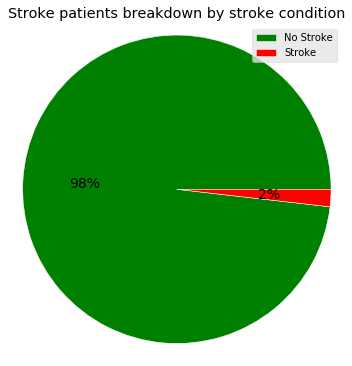

In [10]:
# Function: group dataframe by stroke conditions:
def grp_df_stroke(x):
    df_grp_stroke = pd.DataFrame(df_cleaned.groupby(x)[x].count())
    df_grp_stroke.columns = ['count']
    return df_grp_stroke

# Grouped dataframe by stroke conditions:
df_grp_stroke = grp_df_stroke('stroke')

# Function: plot a pie chart
def pie_plot(x,y,c):
    fig = plt.gcf()
    fig.set_size_inches(5,5)
    plt.pie(x, colors = c, autopct = '%.0f%%', startangle=0,
           wedgeprops = {'edgecolor':'white'}, textprops = {'fontsize':14})
    plt.legend(labels = y, loc='upper right')
    plt.axis('equal')
    plt.tight_layout()

# Plot a pie chart patients breakdown by stroke condition:
pie_plot(df_grp_stroke, ['No Stroke', 'Stroke'], ['green', 'red'])
plt.title('Stroke patients breakdown by stroke condition')
plt.show()

### Count frequencies: on a stroke condition grouped by lifestyle and health indicators ###

In [11]:
# Function: group dataframe by a categorical factor
def df_grp(x,y):
    df_grp = pd.DataFrame(df_cleaned.groupby([y,x])[x].count())
    df_grp.columns = ['count']
    return df_grp

# Count frequencies: demographic factors on a stroke condition
df_grp_gender = df_grp('gender','stroke')
df_grp_marital = df_grp('ever_married','stroke')
df_grp_residential = df_grp('Residence_type','stroke')
df_grp_worktype = df_grp('work_type','stroke')

# Count frequencies: health indiator factors on a stroke condition
df_grp_smoking = df_grp('smoking_status','stroke')
df_grp_hypertension = df_grp('hypertension','stroke')
df_grp_heart = df_grp('heart_disease','stroke')

### Frequency counts in percent for patient population: by demographic factors ###

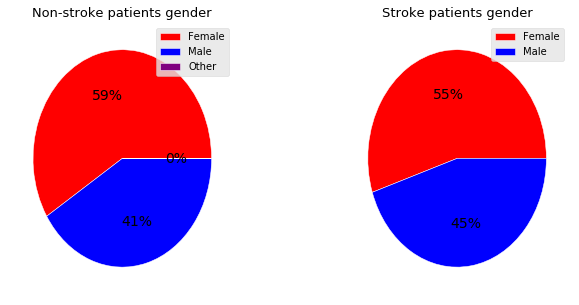

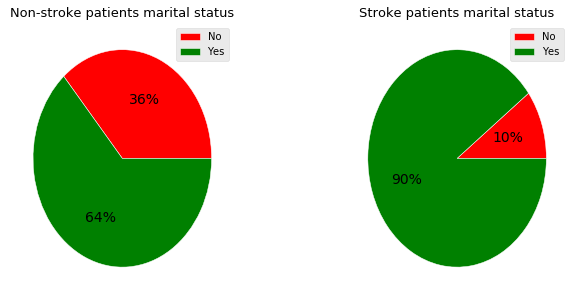

In [12]:
# Function: split a grouped dataframe by stroke conditions
def df_grp_split(df):
    df_grp_0 = df.loc[0]
    df_grp_1 = df.loc[1]
    return (df_grp_0, df_grp_1)

# Function: plot a pie chart with two subplots
def pie_subplots(x1,x2,y,var,c):
    f,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    # Subplot for non-stroke:
    ax1.pie(x1, colors=c, autopct='%.0f%%', 
           wedgeprops={'edgecolor':'white'}, textprops={'fontsize':14})
    ax1.set_title('Non-stroke patients ' + var, fontsize=13)
    ax1.legend(labels = y, loc='upper right')
    # Subplot for non-stroke:
    ax2.pie(x2, colors=c, autopct='%.0f%%', 
           wedgeprops={'edgecolor':'white'}, textprops={'fontsize':14})
    ax2.set_title('Stroke patients ' + var, fontsize=13)
    ax2.legend(labels = y, loc='upper right')
    
# Split a grouped dataframe for stroke vs. non-stroke by gender: 
df_grp_gender_0, df_grp_gender_1 = df_grp_split(df_grp_gender)

# Split a grouped dataframe for stroke vs. non-stroke by marital status: 
df_grp_marital_0, df_grp_marital_1 = df_grp_split(df_grp_marital)

plt.figure()
# Plot a pie chart breakdown by gender for stroke vs. non-stroke:
pie_subplots(df_grp_gender_0, df_grp_gender_1, df_grp_gender_0.index,
             'gender', ['red','blue','purple'])
plt.show()

# Plot a pie chart breakdown by marital status for stroke vs. non-stroke:
pie_subplots(df_grp_marital_0, df_grp_marital_1, df_grp_marital_0.index,
             'marital status', ['red','green'])
plt.show()

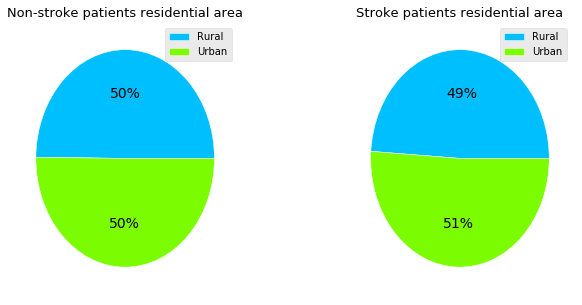

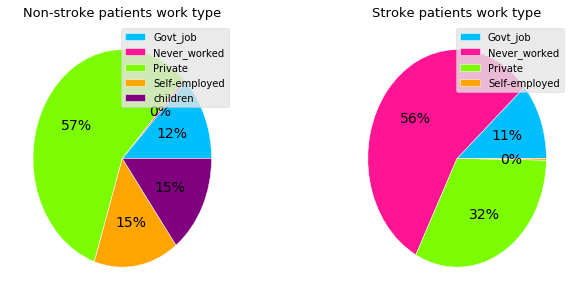

In [13]:
# Split a grouped dataframe for stroke vs. non-stroke by residential: 
df_grp_residential_0, df_grp_residential_1 = df_grp_split(df_grp_residential)
# Split a grouped dataframe for stroke vs. non-stroke by worktype: 
df_grp_worktype_0, df_grp_worktype_1 = df_grp_split(df_grp_worktype)

plt.figure()
# Plot a pie chart breakdown by residential for stroke vs. non-stroke:
pie_subplots(df_grp_residential_0, df_grp_residential_1, df_grp_residential_0.index,
             'residential area', ['deepskyblue','lawngreen'])
plt.show()

# Plot a pie chart breakdown by worktype for stroke vs. non-stroke:
pie_subplots(df_grp_worktype_0, df_grp_worktype_1, df_grp_worktype_0.index,
             'work type', ['deepskyblue','deeppink','lawngreen','orange','purple'])
plt.show()

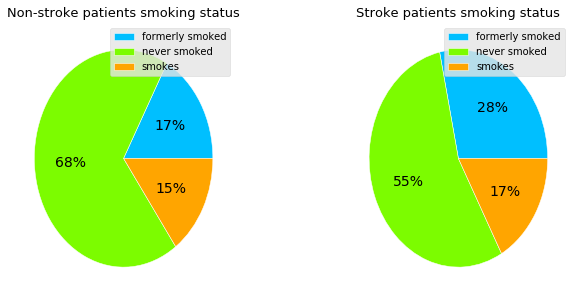

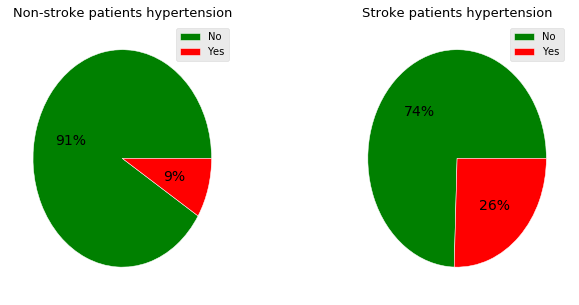

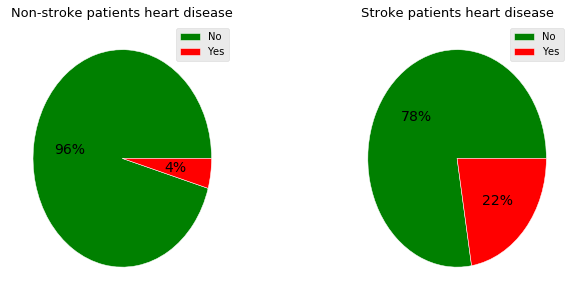

In [14]:
# Split a grouped dataframe for stroke vs. non-stroke by smoking: 
df_grp_smoking_0, df_grp_smoking_1 = df_grp_split(df_grp_smoking)

# Split a grouped dataframe for stroke vs. non-stroke by hypertension: 
df_grp_hypertension_0, df_grp_hypertension_1 = df_grp_split(df_grp_hypertension)

# Split a grouped dataframe for stroke vs. non-stroke by heart_disease: 
df_grp_heart_0, df_grp_heart_1 = df_grp_split(df_grp_heart)

plt.figure()
# Plot a pie chart breakdown by smoking for stroke vs. non-stroke:
pie_subplots(df_grp_smoking_0, df_grp_smoking_1, df_grp_smoking_0.index,
             'smoking status', ['deepskyblue','lawngreen','orange'])
plt.show()
# Plot a pie chart breakdown by hypertension for stroke vs. non-stroke:
pie_subplots(df_grp_hypertension_0, df_grp_hypertension_1, df_grp_hypertension_0.index,
             'hypertension', ['green','red'])
plt.show()
# Plot a pie chart breakdown by heart_disease for stroke vs. non-stroke:
pie_subplots(df_grp_heart_0, df_grp_heart_1, df_grp_heart_0.index,
             'heart disease', ['green','red'])
plt.show()

### Histogram: Continous Varaibles ###
Distribution of age, BMI and average glucose level on patient population. Distributions were plotted separately on same kind of figure for each group of stroke and non-stroke population.

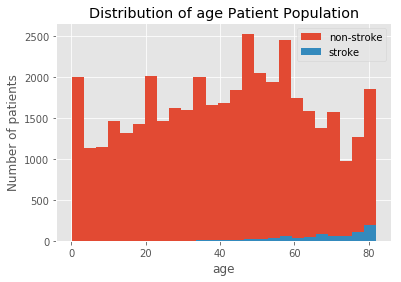

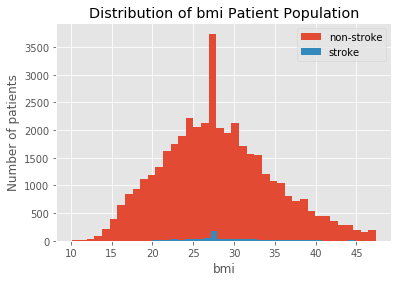

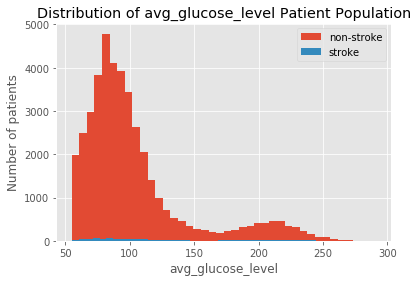

In [15]:
# Grouped dataframe by stroke label:
ag = df_cleaned.groupby('stroke')

# Function: plot a histogram:
def plot_hist(x,y,bins):
    ag[x].hist(bins=bins, label=ag[y])
    plt.title('Distribution of '+x+ ' Patient Population')
    plt.xlabel(x)
    plt.ylabel('Number of patients')
    plt.legend(('non-stroke','stroke'), loc='upper right')

# Visualization: continuous scale data #
###############################################################################
# Histogram: age
plot_hist('age','stroke', 25)
plt.show()

# Histogram: bmi
plot_hist('bmi','stroke', 40)
plt.show()

# Histogram: avg_glucose_level
plot_hist('avg_glucose_level','stroke', 40)
plt.show()

### Summary of distributions by age, bmi and average glucose level: ###
* Age: Distribution of age on stroke population indicated that majority of patients were senior (i.e., skewed to left).
* BMI: A uniform distribution on both populations. Most of stroke patients were in BMI range between from 25 to 27.
* Avg_glucose_level: a histogram showed non-uniform distribution on both populations. Most of non-stroke population were non-diabetic as shown above figure. On the other hand, distribution of mean glucose on stroke population showed bi-modal peaks.

### Correlation Matrix: Training Set [imbalanced] ###

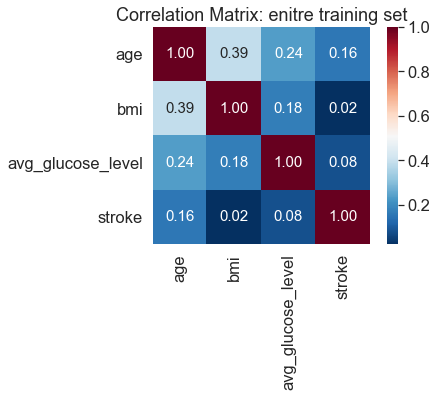

In [16]:
# Correlation Matrix Plot: entire dataset #
###############################################################################
# Column names of cleaned dataframe
cols = ['age','bmi','avg_glucose_level','stroke']

# Plot correlation matrix heatmap
plt.figure()
cm = np.corrcoef(df_cleaned[cols].values.T)
sns.set(font_scale = 1.5)
hm = sns.heatmap(cm, cmap='RdBu_r', cbar=True,
                 annot=True, square=True, fmt='.2f',
                 annot_kws={'size':15}, yticklabels=cols, xticklabels=cols)
plt.title('Correlation Matrix: enitre training set')
plt.show()

### EDA: stroke patients only ###
To have better understanding on stroke patients feature interaction, a separate sample only consists of stroke cases was prepared. Correlation matrix plot was plotted to show the trends among these three numerical features.

C:\Users\yoots\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3167: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\yoots\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3168: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


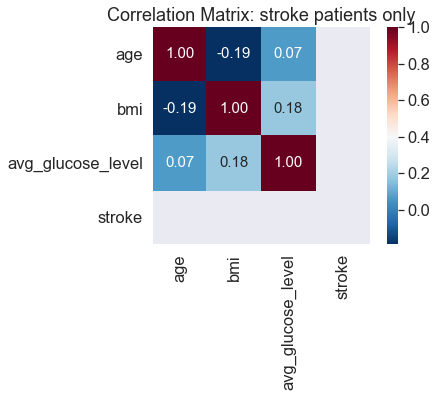

In [17]:
# Split dataframe by a stroke label: '0':non-stroke, '1':stroke #
###############################################################################
df_stroke_0 = df_cleaned[df_cleaned['stroke'] == 0] # only non-stroke patients
df_stroke_1 = df_cleaned[df_cleaned['stroke'] == 1] # only stroke patients

# Extracted columns for correlation matrix plot:
cols = ['age','bmi','avg_glucose_level','stroke']

# Correlation Matrix Plot #
# CM plot of stroke patients only:
plt.figure()
cm_stroke = np.corrcoef(df_stroke_1[cols].values.T)
sns.set(font_scale = 1.5)
_ = sns.heatmap(cm_stroke, cmap='RdBu_r', cbar=True,
                annot=True, square=True, fmt='.2f',
                annot_kws={'size':15}, yticklabels=cols, xticklabels=cols)
plt.title('Correlation Matrix: stroke patients only')
plt.show()

### Bar Charts: mean diagnostic metrics of stroke patients factored by stroke conditions ###

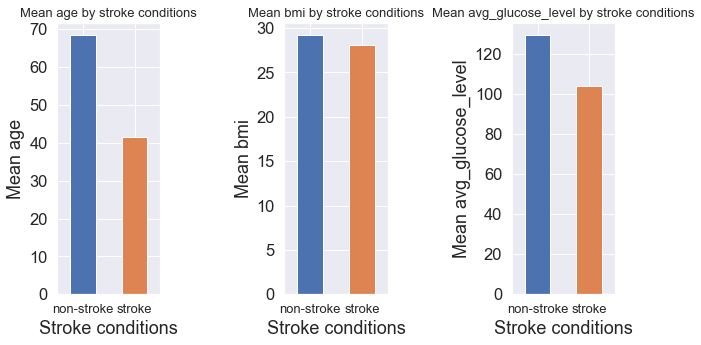

In [18]:
# Function: a bar chart on mean diagnostic metrics by stroke conditions
def bar_plot(x1,x2,x3,y):
    # Convert labels into text label:
    lb = [0,1]
    labels=['non-stroke','stroke']
    plt.figure(figsize=(10,5))
    plt.subplots_adjust(wspace=1.2)
    # Mean age factored by "stroke condition":
    plt.subplot(1,3,1)    
    df_cleaned.groupby(y)[x1].mean().sort_values(ascending=False).plot(kind='bar')
    plt.xticks(lb, labels, rotation=0, fontsize=13)
    plt.xlabel('Stroke conditions', )
    plt.ylabel('Mean '+x1)
    plt.title('Mean ' +x1+ ' by stroke conditions', fontsize=13)
    # Mean bmi factored by "stroke condition":
    plt.subplot(1,3,2)
    df_cleaned.groupby(y)[x2].mean().sort_values(ascending=False).plot(kind='bar')
    plt.xticks(lb, labels, rotation=0, fontsize=13)
    plt.xlabel('Stroke conditions')
    plt.ylabel('Mean '+x2)
    plt.title('Mean ' +x2+ ' by stroke conditions', fontsize=13)
    # Mean avg_glucose_level factored by "stroke condition":
    plt.subplot(1,3,3)
    df_cleaned.groupby(y)[x3].mean().sort_values(ascending=False).plot(kind='bar')
    plt.xticks(lb, labels, rotation=0, fontsize=13)
    plt.xlabel('Stroke conditions')
    plt.ylabel('Mean '+x3)
    plt.title('Mean ' +x3+ ' by stroke conditions', fontsize=13)
    
# Visualization: categorical data #
bar_plot('age','bmi','avg_glucose_level','stroke')
plt.show()

### Bar Charts: mean age of stroke patients factored by life style factors ###

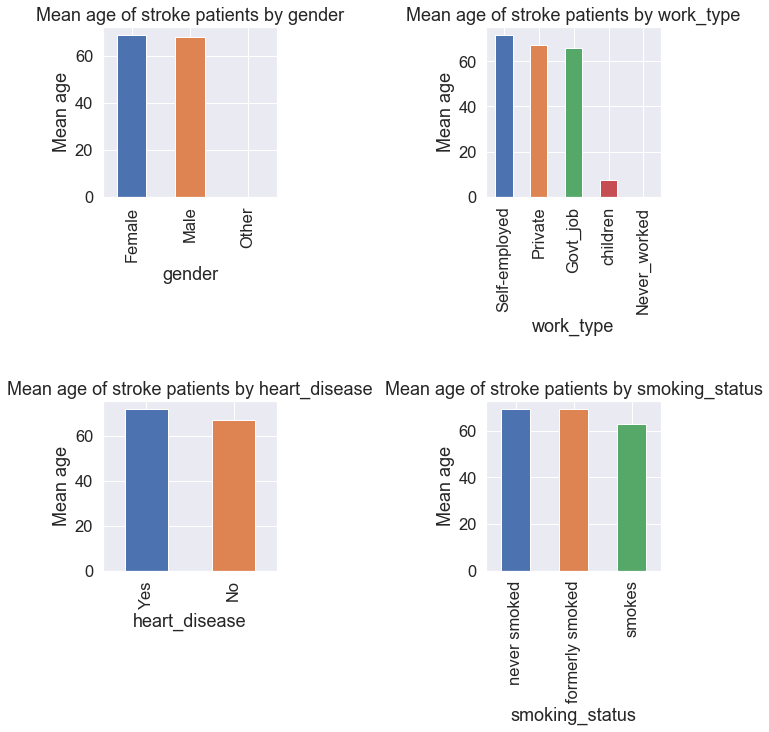

In [19]:
# Function: a bar chart on mean age by lifestyle factors
def cat_plot(x,y1,y2,y3,y4):
    plt.figure(figsize=(10,10))
    plt.subplots_adjust(hspace=1.2, wspace=1.2)
    # By Gender:
    plt.subplot(2,2,1)
    df_stroke_1.groupby(y1)[x].mean().sort_values(ascending=False).plot(kind='bar')
    plt.xlabel(y1)
    plt.ylabel('Mean '+ x)
    plt.title('Mean age of stroke patients by ' + y1)
    # By Gender:
    plt.subplot(2,2,2)
    df_stroke_1.groupby(y2)[x].mean().sort_values(ascending=False).plot(kind='bar')
    plt.xlabel(y2)
    plt.ylabel('Mean '+ x)
    plt.title('Mean age of stroke patients by ' + y2)
    # By Gender:
    plt.subplot(2,2,3)
    df_stroke_1.groupby(y3)[x].mean().sort_values(ascending=False).plot(kind='bar')
    plt.xlabel(y3)
    plt.ylabel('Mean '+ x)
    plt.title('Mean age of stroke patients by ' + y3)
    # By Gender:
    plt.subplot(2,2,4)
    df_stroke_1.groupby(y4)[x].mean().sort_values(ascending=False).plot(kind='bar')
    plt.xlabel(y4)
    plt.ylabel('Mean '+ x)
    plt.title('Mean age of stroke patients by ' + y4)        

    
cat_plot('age','gender','work_type','heart_disease','smoking_status')
plt.show()

### Compute Summary Statistics: stroke vs. non-stroke patients ###

In [20]:
# Compute summary statistics: stroke vs. non-stroke patients #
###############################################################################
# Stroke patients only:
df_stroke_1_stat = df_stroke_1.describe().T
# Reorder columns order in summary dataframe
df_stroke_1_stat = df_stroke_1_stat[['count','min','max','mean','25%','50%','75%','std']]
# Drop 'stroke' column:
df_stroke_1_stat = df_stroke_1_stat.drop(['stroke'])
# Print summary stat.:
print(df_stroke_1_stat)

# Non-stroke patients only:
df_stroke_0_stat = df_stroke_0.describe().T
# Reorder columns order in summary dataframe
df_stroke_0_stat = df_stroke_0_stat[['count','min','max','mean','25%','50%','75%','std']]
# Drop 'stroke' column:
df_stroke_0_stat = df_stroke_0_stat.drop(['stroke'])
# Print summary stat.:
print(df_stroke_0_stat)

                   count    min     max        mean      25%     50%  \
age                772.0   1.32   82.00   68.360518  60.0000   71.00   
avg_glucose_level  772.0  55.01  271.74  129.025946  80.7025  103.64   
bmi                772.0  14.30   46.40   29.168135  26.4000   27.60   

                        75%        std  
age                 79.0000  12.179318  
avg_glucose_level  191.6625  59.505707  
bmi                 31.7000   5.289833  
                     count    min     max        mean    25%    50%       75%  \
age                41740.0   0.08   82.00   41.668239  23.00  43.00   59.0000   
avg_glucose_level  41740.0  55.00  291.05  103.604497  77.47  91.36  111.2425   
bmi                41740.0  10.10   47.40   28.036100  23.30  27.60   32.2000   

                         std  
age                22.518284  
avg_glucose_level  42.126531  
bmi                 6.797340  


### Age Stratification ###
* This will help us to stratify non-stroke and stroke patients sample with respect to their associated age groups.
* Age group: x<30, 30-40, 40-50, 50-60, 60-70, 70-80, 80-90

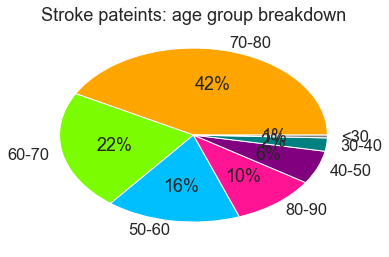

In [21]:
######################
# Age stratification #
######################
# Function: Split a dataframe by age group for stroke vs. non-stroke
def df_grp_age_group(df0, df1, x):
    # Stroke patients group:
    df_grp_age_group_1 = pd.DataFrame(df1.groupby(x)[x].count().sort_values(ascending=False))
    df_grp_age_group_1.columns = ['count']
    df_grp_age_group_1.index.name = 'age_group'
    # Non-stroke patients group:
    df_grp_age_group_0 = pd.DataFrame(df0.groupby(x)[x].count().sort_values(ascending=False))
    df_grp_age_group_0.columns = ['count']
    df_grp_age_group_0.index.name = 'age_group'
    return (df_grp_age_group_1, df_grp_age_group_0)

# Split dataframe by age group for stroke vs. non-stroke:
df_grp_age_group_1, df_grp_age_group_0 = df_grp_age_group(df_stroke_0, df_stroke_1, 'age_group')    

# Plot a pie chart: age group composition on stroke patients
plt.pie(df_grp_age_group_1.loc[:,('count')], labels=['70-80','60-70','50-60','80-90','40-50','30-40','<30'], 
        autopct='%.0f%%', colors=['orange','lawngreen','deepskyblue','deeppink','purple','teal','gray'])
plt.title('Stroke pateints: age group breakdown')
plt.show()

In [22]:
# Age stratification on non-stroke patients sample #
###############################################################################
# Stratified by age_group_label:
df_stroke_0_age_grp1 = df_stroke_0[df_stroke_0['age_group_label'] == 1] # age: <30 
df_stroke_0_age_grp2 = df_stroke_0[df_stroke_0['age_group_label'] == 2] # age: 30-40
df_stroke_0_age_grp3 = df_stroke_0[df_stroke_0['age_group_label'] == 3] # age: 40-50
df_stroke_0_age_grp4 = df_stroke_0[df_stroke_0['age_group_label'] == 4] # age: 50-60
df_stroke_0_age_grp5 = df_stroke_0[df_stroke_0['age_group_label'] == 5] # age: 60-70
df_stroke_0_age_grp6 = df_stroke_0[df_stroke_0['age_group_label'] == 6] # age: 70-80
df_stroke_0_age_grp7 = df_stroke_0[df_stroke_0['age_group_label'] == 7] # age: 80-90

# Calculate proportion (%) of stroke patients by age group:
df_grp_age_group_1['pct'] = df_grp_age_group_1/df_grp_age_group_1.sum()

# Print the count index for each age group from stroke patients:
print(df_grp_age_group_1.sort_index())

           count       pct
age_group                 
(0, 30]        4  0.005181
(30, 40]      19  0.024611
(40, 50]      48  0.062176
(50, 60]     125  0.161917
(60, 70]     172  0.222798
(70, 80]     325  0.420984
(80, 90]      79  0.102332


### Analysis on a balanced dataset with matching age distribution ###
To explain any hidden co-variates besides age, case control analysis was performed. We took equal sample size of n=783 from non-stroke patient population in order to match out the sample size of stroke population. Also exactly same # of cases from stroke population's each age group were taken from non-stroke population.

In [23]:
# Downsampling on non-stroke patients by stroke patients proporition %
###############################################################################
# Multiplied by sample size of stroke patients population x stroke patients proportion (%) on each age group:
sampled_0a_age_grp1 = resample(df_stroke_0_age_grp1, replace=True, 
                               n_samples=4,random_state=0)
sampled_0a_age_grp2 = resample(df_stroke_0_age_grp2, replace=True, 
                               n_samples=21,random_state=0)
sampled_0a_age_grp3 = resample(df_stroke_0_age_grp3, replace=True, 
                               n_samples=50,random_state=0)
sampled_0a_age_grp4 = resample(df_stroke_0_age_grp4, replace=True, 
                               n_samples=129,random_state=0)
sampled_0a_age_grp5 = resample(df_stroke_0_age_grp5, replace=True, 
                               n_samples=174,random_state=0)
sampled_0a_age_grp6 = resample(df_stroke_0_age_grp6, replace=True, 
                               n_samples=326,random_state=0)
sampled_0a_age_grp7 = resample(df_stroke_0_age_grp7, replace=True, 
                               n_samples=79,random_state=0)

# Concatentate downsampled majority class: "non-stroke" patients by all age groups
df_stroke_0a_downsampled = pd.concat([sampled_0a_age_grp1,sampled_0a_age_grp2,sampled_0a_age_grp3,
                                  sampled_0a_age_grp4,sampled_0a_age_grp5,sampled_0a_age_grp6,
                                  sampled_0a_age_grp7], axis=0)

# Conbine minority class: "stroke" patients with downsampled non-stroke patients
df_downsampled_stroke_0a = pd.concat([df_stroke_0a_downsampled,df_stroke_1],axis=0)

### Correlation Matrix: balanced dataset with matching age distribution ###
Resampling: downsampling on majority class label (non-stroke) with matching # of cases from each age group

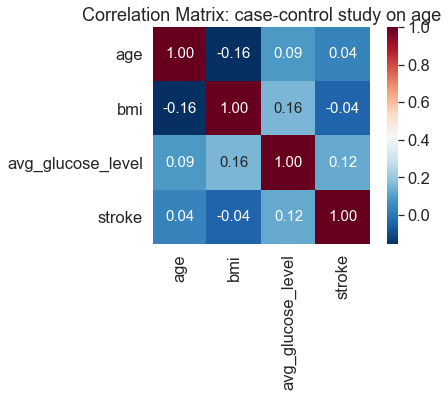

In [24]:
# Correlation Matrix Plot: age controlled downsampled set #
###############################################################################
# CM plot of downsampled majority: "0" non-stroke patients
cm_downsampled_stroke_0a = np.corrcoef(df_downsampled_stroke_0a[cols].values.T)
sns.set(font_scale = 1.5)
hm = sns.heatmap(cm_downsampled_stroke_0a, cmap='RdBu_r', cbar=True,
                 annot=True, square=True, fmt='.2f',
                 annot_kws={'size':15}, yticklabels=cols, xticklabels=cols)
plt.title('Correlation Matrix: case-control study on age')
plt.show()

### Summary: Analysis of Randomized Downsampling on non-stroke Patient Population ###
* From above case control analysis, we were able to identify other hidden co-variates (i.e., bmi, avg. glucose level) besides age. Now, we performed resampling on a group of non-stroke patients by randomized negative sub-sampling. The dataset was highly imbalanced where majority of cases were non-stroke (98%) and only 2% were stroke cases. 
* Thus, resampling (i.e., negative sub-sampling) was applied to address this issue. For example, if a model was constructed using imbalanced dataset, it would not be useful at all. Since most of time, model we built will be good at predicting future incoming cases as non-stroke patients. So it is important to think of classifier as a cost sensitive function. Thus, model gets trained on more positive samples, it will be better at predicting stroke patient cases.
* After downsampling, the resampled dataset achieved an equal ratio of stroke and non-stroke cases with a sample size of n=1566.

In [25]:
# Resampling: non-stroke patients proportion of age groups % #
####################################################################
# Calculate proportion (%) of non-stroke patients by age group:
df_grp_age_group_0['pct'] = df_grp_age_group_0/df_grp_age_group_0.sum()

# Print the count index for each age group from non-stroke patients population:
print(df_grp_age_group_0.sort_index())

           count       pct
age_group                 
(0, 30]    14084  0.337422
(30, 40]    5321  0.127480
(40, 50]    6168  0.147772
(50, 60]    6371  0.152635
(60, 70]    4949  0.118567
(70, 80]    4038  0.096742
(80, 90]     809  0.019382


In [26]:
# Downsampling on non-stroke patients by non-stroke patients proportion %
###############################################################################
# Multiplied by sample size of stroke patients population x non-stroke patients proportion (%) on each age group:
sampled_0b_age_grp1 = resample(df_stroke_0_age_grp1, replace=True, 
                               n_samples=261,random_state=0)
sampled_0b_age_grp2 = resample(df_stroke_0_age_grp2, replace=True, 
                               n_samples=101,random_state=0)
sampled_0b_age_grp3 = resample(df_stroke_0_age_grp3, replace=True, 
                               n_samples=117,random_state=0)
sampled_0b_age_grp4 = resample(df_stroke_0_age_grp4, replace=True, 
                               n_samples=121,random_state=0)
sampled_0b_age_grp5 = resample(df_stroke_0_age_grp5, replace=True, 
                               n_samples=93,random_state=0)
sampled_0b_age_grp6 = resample(df_stroke_0_age_grp6, replace=True, 
                               n_samples=75,random_state=0)
sampled_0b_age_grp7 = resample(df_stroke_0_age_grp7, replace=True, 
                               n_samples=15,random_state=0)

# Concatentate downsampled majority class: "non-stroke" patients by all age groups
df_stroke_0b_downsampled = pd.concat([sampled_0b_age_grp1,sampled_0b_age_grp2,sampled_0b_age_grp3,
                                  sampled_0b_age_grp4,sampled_0b_age_grp5,sampled_0b_age_grp6,
                                  sampled_0b_age_grp7], axis=0)

# Conbine minority class: "stroke" patients with downsampled non-stroke patients
df_downsampled_stroke_0b = pd.concat([df_stroke_0b_downsampled,df_stroke_1],axis=0)

# Remove age group, age group label
df_downsampled_stroke_0b = df_downsampled_stroke_0b.drop(['age_group','age_group_label'], axis=1)

### Correlation Matrix: randomized downsampling for non-stroke patients population ###

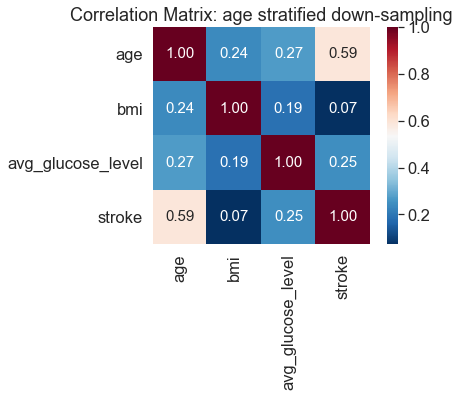

In [27]:
# Correlation Matrix Plot: age stratified random downsampled set #
###############################################################################
# CM plot of downsampled majority: "0" non-stroke patients by minority class %
cm_downsampled_stroke_0b = np.corrcoef(df_downsampled_stroke_0b[cols].values.T)
sns.set(font_scale = 1.5)
hm = sns.heatmap(cm_downsampled_stroke_0b, cmap='RdBu_r', cbar=True,
                 annot=True, square=True, fmt='.2f',
                 annot_kws={'size':15}, yticklabels=cols, xticklabels=cols)
plt.title('Correlation Matrix: age stratified down-sampling')
plt.show()

## Linear Regression Analysis: Balanced Dataset ##
To further explore the relationship of age and average glucose level, a linear regression analysis was performed on the balanced dataset. Relationship of age and avg. glucose level was explored by using a marital status and a stroke condition for condition factors. We selected a marital status and a stroke condition for conditional factors because they showed similar trends (i.e., distribution of scatter plots conditioned by stroke population and married population). Thus, we wanted to analyze this interesting insight by calculating Pearson correlation value.

In [28]:
# Split age and glucose features into two groups of different population:
# Stroke patients group:
age_1a = df_downsampled_stroke_0b[df_downsampled_stroke_0b['stroke'] == 1]['age']
glucose_1a = df_downsampled_stroke_0b[df_downsampled_stroke_0b['stroke'] == 1]['avg_glucose_level']

# Non-stroke patients group: 
age_0a = df_downsampled_stroke_0b[df_downsampled_stroke_0b['stroke'] == 0]['age']
glucose_0a = df_downsampled_stroke_0b[df_downsampled_stroke_0b['stroke'] == 0]['avg_glucose_level']

# Married patients group:
age_1b = df_downsampled_stroke_0b[df_downsampled_stroke_0b['ever_married'] == 'Yes']['age']
glucose_1b = df_downsampled_stroke_0b[df_downsampled_stroke_0b['ever_married'] == 'Yes']['avg_glucose_level']

# Single patients group: 
age_0b = df_downsampled_stroke_0b[df_downsampled_stroke_0b['ever_married'] == 'No']['age']
glucose_0b = df_downsampled_stroke_0b[df_downsampled_stroke_0b['ever_married'] == 'No']['avg_glucose_level']

### Define Pearson Correlation Function ###

In [29]:
# Pearson correlation coefficient:
def pearson_r(x,y):
    corr_mat = np.corrcoef(x,y)
    return corr_mat[0,1]

# Compute correlation coefficient #
# r: age vs. bmi [stroke population]
r1a = pearson_r(age_1a,glucose_1a)
print(r1a)

# r: age vs. bmi [non-stroke population]
r0a = pearson_r(age_0a,glucose_0a)
print(r0a)

# r: age vs. bmi [married population]
r1b = pearson_r(age_1b,glucose_1b)
print(r1b)

# r: age vs. bmi [single population]
r0b = pearson_r(age_0b,glucose_0b)
print(r0b)

0.066419639133
0.265376707347
0.189690709015
0.325423230056


### Faceted Scatter Plot ###
* A pair of regression fitted plots will be drawn based on categorical conditions.
* Relationship between age vs. average glucose level to be observed by Pearson r value.

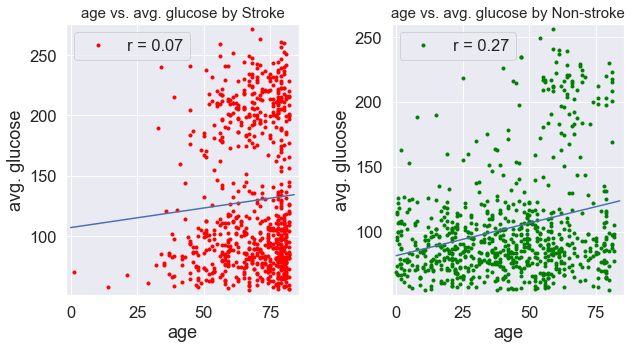

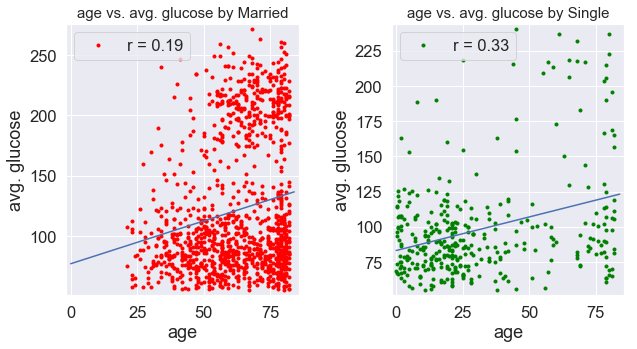

In [30]:
# Write a function: scatter plot + linear regression fit #
##########################################################
def plot_linreg_pair(x1,y1,r1,
                     x0,y0,r0,
                     var1,var2,
                     lab1, lab2):
    plt.figure(figsize=(10,5))
    plt.subplots_adjust(wspace=0.4)
    # Plot on [stroke population]
    plt.subplot(1,2,1)
    plt.plot(x1,y1, 'r--', label='r = %.2f' % r1,
            marker='.', linestyle='none', color='red')
    plt.margins(0.02)
    plt.legend(loc='upper left')
    plt.xlabel(var1)
    plt.ylabel(var2)
    plt.title(var1 + ' vs. ' + var2 + ' by ' + lab1, fontsize=15)
    # Fit linear regression:
    a,b = np.polyfit(x1,y1,1)
    x = np.array([0, 84])
    y = a*x + b
    plt.plot(x,y)
    
    # Plot on [Non-stroke population]
    plt.subplot(1,2,2)
    plt.plot(x0,y0, 'g--', label='r = %.2f' % r0,
            marker='.', linestyle='none', color='green')
    plt.margins(0.02)
    plt.legend(loc='upper left')
    plt.xlabel(var1)
    plt.ylabel(var2)
    plt.title(var1 + ' vs. ' + var2 + ' by ' + lab2, fontsize=15)
    # Fit linear regression:
    a,b = np.polyfit(x0,y0,1)
    x = np.array([0, 84])
    y = a*x + b
    plt.plot(x,y)

# Plot regression fit pair of plots by stroke condition:
plot_linreg_pair(age_1a, glucose_1a, r1a,
                age_0a, glucose_0a, r0a,
                 'age', 'avg. glucose', 
                 'Stroke', 'Non-stroke')
plt.show()

# Plot regression fit pair of plots by marital status:
plot_linreg_pair(age_1b, glucose_1b, r1b,
                age_0b, glucose_0b, r0b,
                 'age', 'avg. glucose', 
                 'Married', 'Single')
plt.show()

### Summary of Linear Regression Analysis ###
* Faceted by a stroke condition: a scatter plot faceted by a stroke population showed very weak
association (r value of 0.07) between age and average glucose level. As stroke patients got older,
there was a slight increase in average glucose levels. Conversely, non-stroke patient population
showed a bit improvement in correlation with value of 0.27.
* Faceted by a marital status: a scatter plot faceted by a marital status showed weak association (r
value of 0.19) between age and average glucose level. As married patients got older, there was slight
increase in average glucose over time. Conversely, single patient population showed a bit
improvement in correlation with value of 0.33.

## Part C. Machine Learning Modeling: Classificaion ##

### Dummy Variable Encoding: nominal features ###
Dummy variable encoding on nominal feature allows to create a separate column on each feature and its value are only encoded "0" or "1". This dummy indicator get interpreted well to the ML models for making accurate prediction. Also to reduce any potential biases of having multi-colinearity, each feature's first encoded dummy variable must be dropped to avoid dummy variable trap (i.e., where independent variables are highly inter-correlated with each other as one predictor can be predicted from other of similar variables: gender_female vs. gender_male vs. gender_other).

In [31]:
# Perform dummy variable encoding on nominal features #
###############################################################################
# Drop first dummy variable to avoid dummy variable trap on each converted feature!
df2 = pd.get_dummies(df_downsampled_stroke_0b.drop(['stroke'], axis=1),
                          drop_first=True)

# Concatenated with a stroke label on transformed dataframe: 
df2 = pd.concat([df2, df_downsampled_stroke_0b['stroke']], axis=1)

# Display new class counts:
print(df2.stroke.value_counts())

# Print df2:
df2.head()

0    783
1    772
Name: stroke, dtype: int64


,age,avg_glucose_level,bmi,gender_Male,gender_Other,hypertension_Yes,heart_disease_Yes,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_never smoked,smoking_status_smokes,stroke
8658,0.4,113.96,18.2,0,0,0,0,0,0,0,0,1,0,1,0,0
33338,22.0,69.37,37.9,0,0,0,0,0,0,0,0,0,1,1,0,0
30530,25.0,65.21,25.7,0,0,0,0,0,0,1,0,0,1,1,0,0
10284,5.0,117.39,19.2,0,0,0,0,0,0,0,0,1,1,1,0,0
40444,19.0,97.67,20.3,0,0,0,0,0,0,1,0,0,0,1,0,0


### Split on input features and output label ###
For cardiac stroke cases risk stratifcation problem, following set of classifiers were tested which included logistic regression, decision tree, random forest and gradient boosting (XGBoost).

After each model construction, RandomizedSearchCV module was applied to tune hyperparameters (i.e., C, n_estimators, etc.) on each model. This boosted model helps us to achieve the best desired performance for making predictions on patients with high risks of developing a stroke.

In [32]:
# QA check on input features/class label #
###############################################################################
# Re-define input features:
X = df2.iloc[:, :-1].values
# Reduced output feature (label): stroke
y = df2['stroke'].values
# Print unique labels for stroke condition:
print('Class labels:', np.unique(y))

Class labels: [0 1]


### Data Partition & Feature Scaling ###
* First is data partition step. It is an absolute requirement procedure in which split original data into training and test sets for training and evaluation of any machine learning modeling task.

* Second is a feature scaling where different ranges of feature inputs feed into a scaler function (i.e., min-max, logarithmic, etc.). This function will re-scale them into a similar range on each feature. This helps some classification model(s) to handle importance of features in a normalized fashion. Feature scaling was applied before the classification models were constructed.

In [33]:
###############################################################################
# General: data parition - train vs. test set
# Use built-in stratify mode to ensure equal % label splits
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size = 1/4, random_state = 0, stratify=y)

# Check label counts on the split set:
print('Class labels counts in total:', np.bincount(y))
print('Class labels counts in train set:', np.bincount(y_train))
print('Class labels counts in test set:', np.bincount(y_test)) 

# Feature Scaling: 
sc_X = StandardScaler() 
X_train_std = sc_X.fit_transform(X_train) 
X_test_std = sc_X.fit_transform(X_test)    

Class labels counts in total: [783 772]
Class labels counts in train set: [587 579]
Class labels counts in test set: [196 193]


### Feature Selection: using Feature Importance module
FIP module is available on DecisionTree, RandomForest and XGBoost classifiers.

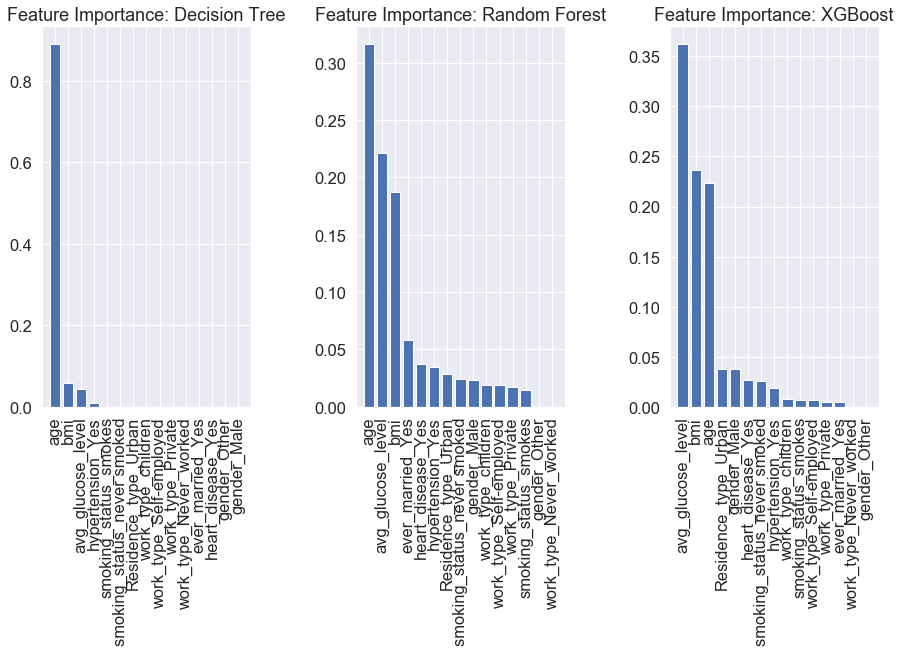

Num Features: 2
Selected Features: [ True False False False False False  True False False False False False
 False False False]
Feature Ranking: [ 1  3  4  7 12  2  1  8 14 10 11  9  5  6 13]


In [34]:
# Feature Selection: Feature Importance #
#########################################
# Write a function F.I.P plot #
def fip_plot(model):
    model = model
    model.fit(X_train_std, y_train)
    feat_labels = df2.columns[:-1]
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    #for f in range(10):
        #print("%2d) %-*s %f" % (f + 1, 30, 
                            #feat_labels[indices[f]],
                            #importances[indices[f]]))

    plt.bar(range(X_train.shape[1]), importances[indices], align='center')
    plt.xticks(range(X_train.shape[1]), feat_labels[indices], rotation=90)
    plt.xlim(-1, X_train.shape[1])
     
plt.figure(figsize=(15,7))
plt.subplots_adjust(wspace=0.5)
     
# Using a Decision Tree:
plt.subplot(1,3,1)
fip_plot(DecisionTreeClassifier(criterion='gini',
                                max_depth=4,
                                random_state=0))
plt.title('Feature Importance: Decision Tree')

# Using a Random Forest:
plt.subplot(1,3,2)
fip_plot(RandomForestClassifier(criterion='gini',
                                n_estimators=25,
                                random_state=0,
                                n_jobs=1))
plt.title('Feature Importance: Random Forest')

# Using a XGBoost:
plt.subplot(1,3,3)
fip_plot(XGBClassifier(n_estimators=100,
                    random_state=0,
                    n_jobs=1,
                    learning_rate=0.2))
plt.title('Feature Importance: XGBoost')
plt.show()     

# Feature Selection: Recursive Feature Elimination #
###############################################################################
# Using Logistic Regression: 
lr = LogisticRegression(random_state=0)
from sklearn.feature_selection import RFE
rfe = RFE(lr, 2) 
rfe.fit(X_train_std, y_train)
print("Num Features: %d" % rfe.n_features_)
print("Selected Features: %s" % rfe.support_)
print("Feature Ranking: %s" % rfe.ranking_)

### Decision Boundary: ML Classifications ###
Visualize decision boundaries for top two selected features on all four classifiers. Following decision boundary plots were plotted to show how well stroke cases were separated from non-stroke cases:
* Logistic Regression: age vs. heart_disease_yes [standardized]
* Decision Tree: age vs. average glucose level [standardized]
* Random Forest: age vs. average glucose level [standardized]
* XGBoost: age vs. BMI [standardized]

In [35]:
# Model Fitting for Decision Boundary Plots #
##############################
# Model: Logistic Regression #
##############################
# Selected input features by LR Classifier: age, heart_disease_yes
X_train_lr = X_train_std[:, [0,6]]
y_train_lr = y_train

# Fit LR Classifier:
lr = LogisticRegression(C=0.1,penalty='l1',random_state=0)
lr.fit(X_train_lr, y_train_lr)

# Model prediction: hold-out test set
X_test_lr = X_test_std[:, [0,7]]
y_pred_test_lr = lr.predict(X_test_lr)

########################
# Model: Decision Tree #
########################
# Selected input features by DTClassifier: age, bmi
X_train_dt = X_train_std[:, [0,2]]
y_train_dt = y_train

# Fit DT Classifier:
tree = DecisionTreeClassifier(criterion='gini', max_depth=8,
                                min_samples_split=2, min_samples_leaf=2,
                                random_state=0)
tree.fit(X_train_dt, y_train_dt)

# Model prediction: hold-out test set
X_test_dt = X_test_std[:, [0,2]]
y_pred_test_dt = tree.predict(X_test_dt)  

########################
# Model: Random Forest #
########################
# Feature Selection by RF Classifier: age, avg_glucose_level
X_train_rf = X_train_std[:, [0,1]]
y_train_rf = y_train

# Fit DT Classifier:    
forest = RandomForestClassifier(criterion='gini',n_estimators=50,
                                max_depth=1, min_samples_split=2,
                                random_state=0, n_jobs=1)
forest.fit(X_train_rf, y_train_rf)

# Model prediction: hold-out test set
X_test_rf = X_test_std[:, [0,1]]
y_pred_test_rf = forest.predict(X_test_rf)

##################
# Model: XGBoost #
##################
# Feature Selection by XGB Classifier: avg_glucose_level, bmi
X_train_xgb = X_train_std[:, [1,2]]
y_train_xgb = y_train

# Fit XGB Classifier:    
xgb = XGBClassifier(n_estimators=50, learning_rate=0.2,
                       max_depth=1, random_state=0, n_jobs=1)
xgb.fit(X_train_xgb, y_train_xgb)

# Model prediction: hold-out test set
X_test_xgb = X_test_std[:, [1,2]]
y_pred_test_xgb = xgb.predict(X_test_xgb)

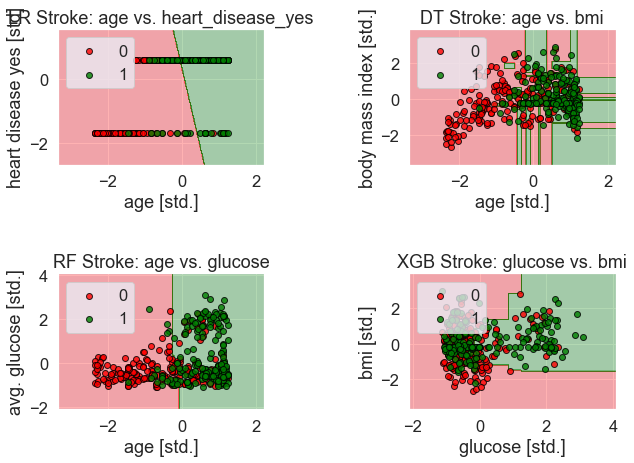

In [36]:
###########################################
# Decision Boundary Plots: ML Classifiers #
###########################################
# Write plot_decision_regions function #
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    # Setup marker generator and colormap
    markers = ('o','o','s','^','v')
    colors = ('red','green','blue','gray','cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # Plot decision surface
    x1_min, x1_max = X[:,0].min()-1, X[:,0].max()+1
    x2_min, x2_max = X[:,1].min()-1, X[:,1].max()+1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y==cl, 0], y=X[y==cl, 1],
                    alpha=0.8, c=colors[idx],
                    marker=markers[idx], label=cl, edgecolor='black')

# Visualize stroke classification: Logistic Regression #
###############################################################################
# hold-out test set
plt.figure(figsize=(10,7))
plt.subplots_adjust(hspace=0.8, wspace=0.7)
plt.subplot(2,2,1)
plot_decision_regions(X=X_test_lr, y=y_test, classifier=lr, test_idx=None)
plt.title('LR Stroke: age vs. heart_disease_yes')
plt.xlabel('age [std.]')
plt.ylabel('heart disease yes [std]')
plt.legend(loc='upper left')

# Visualize stroke classification: Decision Tree #
###############################################################################
# hold-out test set
plt.subplot(2,2,2)
plot_decision_regions(X=X_test_dt, y=y_test, classifier=tree, test_idx=None)
plt.title('DT Stroke: age vs. bmi')
plt.xlabel('age [std.]')
plt.ylabel('body mass index [std.]')
plt.legend(loc='upper left')

# Visualize stroke classification: Random Forest #
###############################################################################
# hold-out test set
plt.subplot(2,2,3)
plot_decision_regions(X=X_test_rf, y=y_test, classifier=forest, test_idx=None)
plt.title('RF Stroke: age vs. glucose')
plt.xlabel('age [std.]')
plt.ylabel('avg. glucose [std.]')
plt.legend(loc='upper left')

# Visualize stroke classification: XGBoost #
###############################################################################
# hold-out test set
plt.subplot(2,2,4)
plot_decision_regions(X=X_test_xgb, y=y_test, classifier=xgb, test_idx=None)
plt.title('XGB Stroke: glucose vs. bmi')
plt.xlabel('glucose [std.]')
plt.ylabel('bmi [std.]')
plt.legend(loc='upper left')
plt.show()    

### K-fold Cross Validation ###

Stratified k-fold cross validation was used for model validation by optimizing model hyperparameters. Firstly, earlier training set portion was used to divide data into multiple folds. In each iteration, one fold was used as validation fold and remaining folds were used for training. Note that this procedures were repeated "k" times and validation fold was shuffled between each iteration. Finally, model performance across all iterations were averaged to provide the best model hyperparameters.

In [37]:
# Define top common selected input features:
X_cm, y_cm = X_train_std[:, [0,1,2,5,6,7,12]], y_train

# K-fold Cross-validation: Stratified #
skf = StratifiedKFold(n_splits=4, random_state=0)
for train_index, val_index in skf.split(X_cm, y_cm):
  #   print("TRAIN:", train_index,  "VALIDATE:", val_index)
    X_train_cm, X_val_cm = X_cm[train_index], X_cm[val_index]
    y_train_cm, y_val_cm = y_cm[train_index], y_cm[val_index]

# Define common test set:
X_test_cm = X_test_std[:, [0,1,2,5,6,7,12]]    

### Model Evaluation: using Feature Selection ###
Compute a normalized confusion matrix and classification metrics on following models:
* Logistic Regression
* Decision Tree Classifier
* Random Forest Classifier
* XGBoost Classifier
* Ensemble Classifier - Majority Vote

### Model 1: Logistic Regression ###
Logistic regression works by using a logit function to transform input value of features and calculate estimated probabilities of a label in range of [0,1]. For example, if P(1=stroke) ≥ 0.5, an observation is predicted as a stroke. Whereas if P(1=stroke) < 0.5, an observation is predicted as a non-stroke.

In [38]:
# Model: Logistic Regression
lr_cv = LogisticRegression(C=0.1,penalty='l1',random_state=0)
lr_cv.fit(X_train_cm, y_train_cm)

# Hyperparameters Tuning:
###############################################################################
# RandomizedSearchCV: LogisticRegression #
# Create hyperparameter options:
param_dist = dict(C=randint(2,100), penalty=['l1','l2'])
random_search = RandomizedSearchCV(estimator=lr_cv, param_distributions=param_dist,
                                   random_state=0, n_iter=100, cv=4)
random_search_lr = random_search.fit(X_val_cm, y_val_cm)

# View best hyperparameters
print('Best Penalty:', random_search_lr.best_estimator_.get_params()['penalty'])
print('Best C:', random_search_lr.best_estimator_.get_params()['C'])

# Model prediction: hold-out test set
X_test_lr = X_test_cm
y_pred_test_lr = random_search_lr.predict(X_test_cm)  

Best Penalty: l2
Best C: 46


### Model 2: Decision Tree ###
Decision tree is an algorithm where it predicts the value of a target variable (label) by learning simple decision rules inferred from selected features. Tree is generated and split data on features. It continues to split in repetitive process at each node until leaves reached purity (i.e., remaining samples at each node belongs to same class either non-stroke
or stroke cases only).

In [39]:
# Model: DecisionTree [cross-validated & std. train set]
tree_cv = DecisionTreeClassifier(criterion='gini', max_depth=8,
                                min_samples_split=2, min_samples_leaf=2,
                                random_state=0)
tree_cv.fit(X_train_cm, y_train_cm)

# Hyperparameters Tuning:
###############################################################################
# Create hyperparameter options:
param_dist_dt = {"criterion": ["gini", "entropy"],
                  "max_depth": randint(10, 100),
                  "max_leaf_nodes": randint(10, 20),
                  "min_samples_split": randint(2, 10),
                  "min_samples_leaf": randint(2, 10)}
random_search = RandomizedSearchCV(estimator=tree_cv, param_distributions=param_dist_dt,
                                   random_state=0, n_iter=100, cv=4)
random_search_dt = random_search.fit(X_val_cm, y_val_cm)

# View best hyperparameters
print('Best min_samples_split:', random_search_dt.best_estimator_.get_params()['min_samples_split'])
print('Best min_samples_leaf:', random_search_dt.best_estimator_.get_params()['min_samples_leaf'])
print('Best max_depth:', random_search_dt.best_estimator_.get_params()['max_depth'])

# Model prediction: hold-out test set
y_pred_test_dt = random_search_dt.predict(X_test_cm)   

Best min_samples_split: 6
Best min_samples_leaf: 4
Best max_depth: 96


### Model 3: Random Forest ###
Random forest is a typical ensemble learning model. It takes random subsample of data from each tree, so all constructed trees are different from each other. Thus, model makes classification based on predictions made from each tree with averaging (i.e., like picking a vote from majority).

In [40]:
# Model: RandomForest [cross-validated & std. train set]
forest_cv = RandomForestClassifier(criterion='gini',n_estimators=50,
                                max_depth=1, min_samples_split=2,
                                random_state=0, n_jobs=1)
forest_cv.fit(X_train_cm, y_train_cm)

# Hyperparameters Tuning:
###############################################################################
# Create hyperparameter options:
param_dist_rf = {"n_estimators": randint(20, 200), 
                 "max_depth": randint(10, 100),
                  "min_samples_split": randint(2, 10),
                  "min_samples_leaf": randint(2, 10),
                  "bootstrap": [True, False],
                  "criterion": ["gini", "entropy"]}
random_search = RandomizedSearchCV(estimator=forest_cv, param_distributions=param_dist_rf,
                                   random_state=0, n_iter=100, cv=4)
random_search_rf = random_search.fit(X_val_cm, y_val_cm)

# View best hyperparameters
print('Best n_estimators:', random_search_rf.best_estimator_.get_params()['n_estimators'])
print('Best max_depth:', random_search_rf.best_estimator_.get_params()['max_depth'])
print('Best min_samples_split:', random_search_rf.best_estimator_.get_params()['min_samples_split'])
print('Best min_samples_leaf:', random_search_rf.best_estimator_.get_params()['min_samples_leaf'])

# Model prediction: hold-out test set
y_pred_test_rf = random_search_rf.predict(X_test_cm)

Best n_estimators: 122
Best max_depth: 51
Best min_samples_split: 5
Best min_samples_leaf: 3


### Model 4: XGBoost ###
XGBoost is a type of gradient boosting model in which subsequent model learns from the mistakes (i.e., residual errors) of previous model in a step-wise forward manner. In Gradient Boosting, residual errors are identified gradients. These gradients help how XGBoost to improve model performances.

In [41]:
# Model: XGBClassifier [cross-validated & std. train set]
xgb_cv = XGBClassifier(n_estimators=50, learning_rate=0.2,
                       max_depth=1, random_state=0, n_jobs=1)
xgb_cv.fit(X_train_cm, y_train_cm)

# Hyperparameters Tuning:
###############################################################################
# Create hyperparameter options:
param_dist_xgb = {"n_estimators": randint(20, 200), 
                 "max_depth": randint(10, 100),
                  "learning_rate": np.random.uniform(0,1,10),
                  "objective": ['binary:logistic','reg:linear'],
                  "booster": ['gbtree','gblinear']}
random_search = RandomizedSearchCV(estimator=xgb_cv, param_distributions=param_dist_xgb,
                                   random_state=0, n_iter=100, cv=4)
random_search_xgb = random_search.fit(X_val_cm, y_val_cm)

# View best hyperparameters
print('Best n_estimators:', random_search_xgb.best_estimator_.get_params()['n_estimators'])
print('Best max_depth:', random_search_xgb.best_estimator_.get_params()['max_depth'])
print('Best learning_rate:', random_search_xgb.best_estimator_.get_params()['learning_rate'])
print('Best objective:', random_search_xgb.best_estimator_.get_params()['objective'])
print('Best booster:', random_search_xgb.best_estimator_.get_params()['booster'])

# Model prediction: hold-out test set
y_pred_test_xgb = random_search_xgb.predict(X_test_cm)

Best n_estimators: 41
Best max_depth: 19
Best learning_rate: 0.0546061434877
Best objective: binary:logistic
Best booster: gblinear


## Ensemble Learning: Majortiy Vote Classifier ##
The goal of ensemble methods is to combine different classifiers into a meta-classifier that has better generalizaion performance than each individual classifier for making predictions. Basically, this majority voting means that we select the class label that has been predicted by majority of classifiers, that is, received more than 50% of the votes. This term "majority voting" applies to binary class problems only which is in our case where class has only two labels (i.e., non-stroke and stroke).

For our case, we were able to train four different classifiers:
1. Logistic Regression
2. Decision Tree
3. Random Forest (ensemble learning: bagging)
4. XGBoost (gradient boosting)

A strong meta-classifier was built to balances out the individual classifiers' weaknesses on particular observations.

In [42]:
#######################################
# Implementing MajorityVoteClassifier #
#######################################
class MajorityVoteClassifier(skb.BaseEstimator, 
                             skb.ClassifierMixin):
    """ A majority vote ensemble classifier

    Parameters
    ----------
    classifiers : array-like, shape = [n_classifiers]
      Different classifiers for the ensemble

    vote : str, {'classlabel', 'probability'} (default='label')
      If 'classlabel' the prediction is based on the argmax of
        class labels. Else if 'probability', the argmax of
        the sum of probabilities is used to predict the class label
        (recommended for calibrated classifiers).

    weights : array-like, shape = [n_classifiers], optional (default=None)
      If a list of `int` or `float` values are provided, the classifiers
      are weighted by importance; Uses uniform weights if `weights=None`.

    """
    def __init__(self, classifiers, vote='classlabel', weights=None):

        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value
                                  in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        """ Fit classifiers.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Matrix of training samples.

        y : array-like, shape = [n_samples]
            Vector of target class labels.

        Returns
        -------
        self : object

        """
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError("vote must be 'probability' or 'classlabel'"
                             "; got (vote=%r)"
                             % self.vote)

        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError('Number of classifiers and weights must be equal'
                             '; got %d weights, %d classifiers'
                             % (len(self.weights), len(self.classifiers)))

        # Use LabelEncoder to ensure class labels start with 0, which
        # is important for np.argmax call in self.predict
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = skb.clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        """ Predict class labels for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Matrix of training samples.

        Returns
        ----------
        maj_vote : array-like, shape = [n_samples]
            Predicted class labels.
            
        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # 'classlabel' vote

            #  Collect results from clf.predict calls
            predictions = np.asarray([clf.predict(X)
                                      for clf in self.classifiers_]).T

            maj_vote = np.apply_along_axis(
                                      lambda x:
                                      np.argmax(np.bincount(x,
                                                weights=self.weights)),
                                      axis=1,
                                      arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        """ Predict class probabilities for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.

        Returns
        ----------
        avg_proba : array-like, shape = [n_samples, n_classes]
            Weighted average probability for each class per sample.

        """
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        """ Get classifier parameter names for GridSearch"""
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s__%s' % (name, key)] = value
            return out

In [43]:
# Test Majority Vote Classifiers #
mv_clf = MajorityVoteClassifier(classifiers=[random_search_lr, random_search_dt,
                                            random_search_rf, random_search_xgb])
clf_labels = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost']
clf_labels += ['Majority Voting']         
all_clf = [random_search_lr, random_search_dt, random_search_rf, random_search_xgb, mv_clf]

# Model prediction: hold-out test set
y_pred_test_mv = mv_clf.fit(X_train_cm,y_train_cm).predict(X_test_cm)

## Model Evaluation: Confusion Matrix ##
A confusion matrix is a table that is often used to describe the performance of a classification model (or "classifier") on a set of test data for which the true values are known.

1. True Positives (TP): These are cases in which model predicted yes (they have the disease), and they do have the disease.
2. True Negatives (TN): Model predicted no, and they don't have the disease.
3. False Positives (FP): Model predicted yes, but they don't actually have the disease. (Also known as a "Type I error.")
4. False Negatives (FN): Model predicted no, but they actually do have the disease. (Also known as a "Type II error.")

In [44]:
# Making the Confusion/Contingency Matrix #
###############################################################################
# Write a function: plot_confusion_matrix #
def plot_confusion_matrix(cm, classes):
    fig, ax = plt.subplots(figsize=(5,5))
    cm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis]*2)
    
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i,j], fmt), ha='center', va='center',
                    color='white' if cm[i,j] > thresh else 'black')    
        
    #plt.tight_layout()
    plt.xlabel('predicted label')
    plt.ylabel('true label')


# Make class labels for "stroke"
class_labels = np.array(['non-stroke','stroke'], dtype=str)        

# Write a function: report classification metrics summary
def rep_class_metrics(y_test, y_pred, model_name):
    print ('Accuracy of ' + model_name + ' is %0.2f'% skm.accuracy_score(y_test, y_pred))
    print ('Precision of ' + model_name + ' is %0.2f'% skm.precision_score(y_test, y_pred))
    print ('Recall of ' + model_name + ' is %0.2f'% skm.recall_score(y_test, y_pred))
    print ('ROC score of ' + model_name + ' is %0.2f'% skm.roc_auc_score(y_test, y_pred))

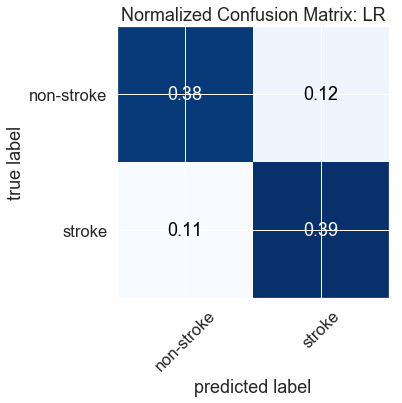

Accuracy of Logistic Regression is 0.76
Precision of Logistic Regression is 0.75
Recall of Logistic Regression is 0.77
ROC score of Logistic Regression is 0.76


In [45]:
# Plot confusion matrix on test set: Logistic Regression
###############################################################################
cm_test_lr = skm.confusion_matrix(y_test, y_pred_test_lr)
np.set_printoptions(precision=2)  

plot_confusion_matrix(cm_test_lr, class_labels)
plt.title('Normalized Confusion Matrix: LR')
plt.show()

# Classification metrics on test set: LogisticRegression
rep_class_metrics(y_test, y_pred_test_lr, 'Logistic Regression')

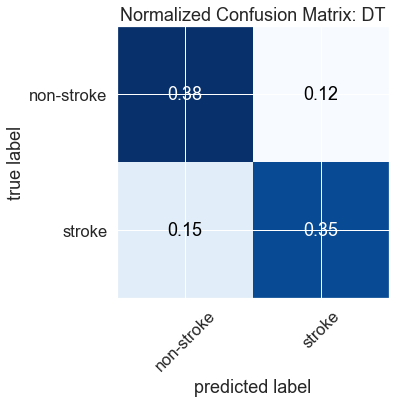

Accuracy of Decision Tree is 0.73
Precision of Decision Tree is 0.74
Recall of Decision Tree is 0.70
ROC score of Decision Tree is 0.73


In [46]:
# Plot confusion matrix on test set: DecisionTree
###############################################################################
cm_test_dt = skm.confusion_matrix(y_test, y_pred_test_dt)  
np.set_printoptions(precision=2)  

plot_confusion_matrix(cm_test_dt, class_labels)
plt.title('Normalized Confusion Matrix: DT')
plt.show()

# Classification metrics on test set: DecisionTree
rep_class_metrics(y_test, y_pred_test_dt, 'Decision Tree')

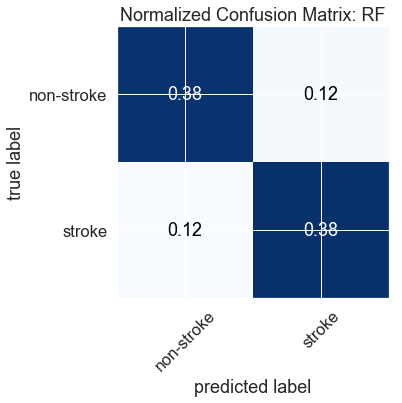

Accuracy of Random Forest is 0.75
Precision of Random Forest is 0.75
Recall of Random Forest is 0.76
ROC score of Random Forest is 0.75


In [47]:
# Plot confusion matrix on test set: RandomForest
###############################################################################
cm_test_rf = skm.confusion_matrix(y_test, y_pred_test_rf)  
np.set_printoptions(precision=2)  

plot_confusion_matrix(cm_test_rf, class_labels)
plt.title('Normalized Confusion Matrix: RF')
plt.show()

# Classification metrics on test set: RandomForest
rep_class_metrics(y_test, y_pred_test_rf, 'Random Forest')

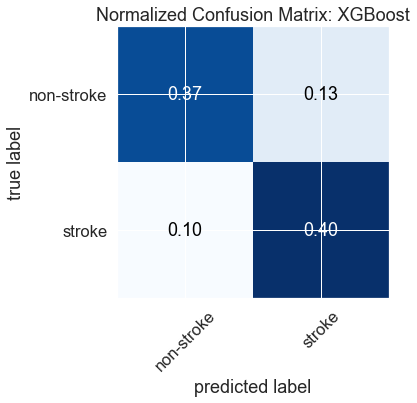

Accuracy of XGBoost is 0.77
Precision of XGBoost is 0.75
Recall of XGBoost is 0.81
ROC score of XGBoost is 0.77


In [48]:
# Plot confusion matrix on test set: XGBoost
###############################################################################
cm_test_xgb = skm.confusion_matrix(y_test, y_pred_test_xgb) 
np.set_printoptions(precision=2)  

plot_confusion_matrix(cm_test_xgb, class_labels)
plt.title('Normalized Confusion Matrix: XGBoost')
plt.show()

# Classification metrics on test set: XGBoost
rep_class_metrics(y_test, y_pred_test_xgb, 'XGBoost')

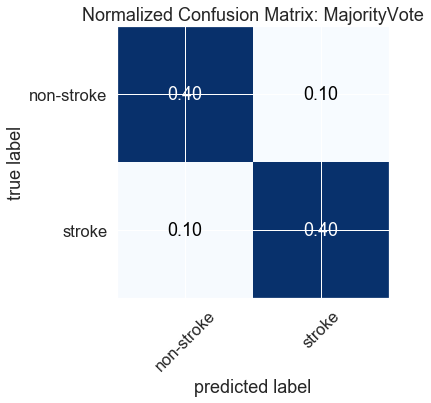

Accuracy of Majority Vote is 0.80
Precision of Majority Vote is 0.80
Recall of Majority Vote is 0.80
ROC score of Majority Vote is 0.80


In [49]:
# Plot confusion matrix on test set: MajorityVote
###############################################################################
cm_test_mv = skm.confusion_matrix(y_test, y_pred_test_mv) 
np.set_printoptions(precision=2)  

plot_confusion_matrix(cm_test_mv, class_labels)
plt.title('Normalized Confusion Matrix: MajorityVote')
plt.show()

# Classification metrics on test set: MajorityVote
rep_class_metrics(y_test, y_pred_test_mv, 'Majority Vote')

## Model Evaluation: precision-recall curve ##
Precision-Recall is a useful measure of success for predictions when the classes of dataset are highly imbalanced. In information retrieval, precision is a measure of result relevancy, while recall is a measure of how many truly relevant results are returned.

The precision-recall curve shows the tradeoff between precision and recall at different thresholds. A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).

In summary, a system with high recall but low precision returns: many predictions where most of prediction results are incorrect when compared to actual true labels. Conversely, a system with low recall and high precision returns: few predictions but most of its prediction results are correct when compared to actual true labels.

Average precision-recall score of MajorityVote model: 0.83


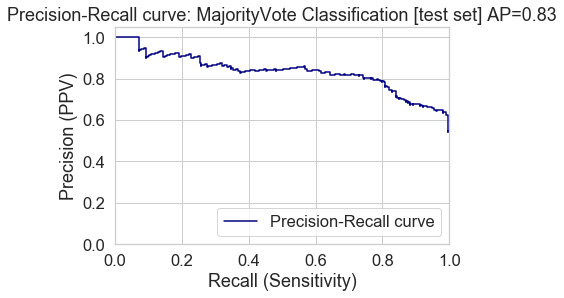

In [50]:
############################################
# Model Evaluation: Precision Recall Curve #
############################################
# Compute average precision score:
###############################################################################
y_score_mv = mv_clf.fit(X_train_cm,y_train_cm).predict_proba(X_test_cm)[:,1]
avg_precision = skm.average_precision_score(y_test, y_score_mv)

print('Average precision-recall score of MajorityVote model: {0:0.2f}'.format(
      avg_precision))

# Plot Precision-Recall curve:
###############################################################################
precision, recall, _ = skm.precision_recall_curve(y_test, y_score_mv)

sns.set_style('whitegrid')

plt.step(recall, precision, color='navy', where='post',label='Precision-Recall curve')
#plt.fill_between(recall, precision, step='post', alpha=0.2, color='navy')
plt.title('Precision-Recall curve: MajorityVote Classification [test set] AP={0:0.2f}'
          .format(avg_precision))
plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision (PPV)')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(loc='lower right')
plt.show()

### Summary of Precision-Recall Curve ###
Overall, the majorite vote classifier (ensemble of all 4 classifiers) showed weighted average precision of 0.83. In other words, about 83% of time, the model is good at making stroke predictions from total # of actual stroke cases.

## Model Evaluation: ROC curve ##

ROC curve typically displays true positive rate on the Y axis, and false positive rate on the X axis. This means that the top left corner of the plot is the “ideal” point - a false positive rate of zero, and a true positive rate of one. This is not very realistic, but it does mean that a larger area under the curve (AUC) is usually better. The “steepness” of ROC curves is also important, since it is ideal to maximize the true positive rate while minimizing the false positive rate.

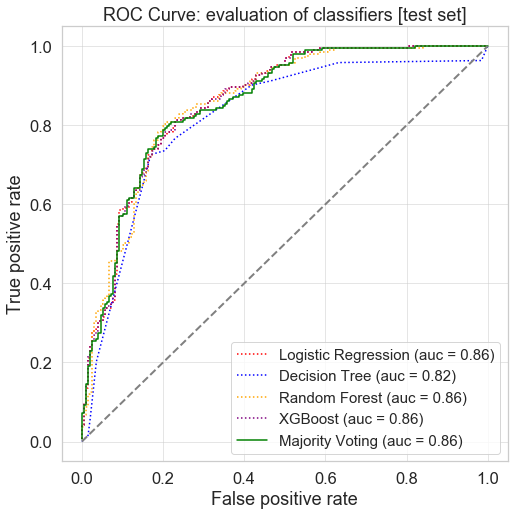

In [51]:
###################################
# Model Evaluation: ROC-AUC Curve #
###################################
# Plot a ROC Curve #
plt.figure(figsize=(8,8))
# ROC for each classifiers
colors = ['red', 'blue', 'orange', 'purple', 'green']
linestyles = [':', ':', ':', ':', '-']
for clf, label, clr, ls \
    in zip(all_clf, clf_labels, colors, linestyles):
        # Asumming the label of the positive class is 1
        y_pred = clf.fit(X_train_cm,
                         y_train_cm).predict_proba(X_test_cm)[:,1]
        fpr, tpr, thresholds = skm.roc_curve(y_true=y_test,
                                         y_score=y_pred)
        roc_auc = skm.auc(x=fpr, y=tpr)
        plt.plot(fpr, tpr, color=clr, linestyle=ls,
                 label='%s (auc = %0.2f)' % (label, roc_auc))
plt.plot([0,1], [0,1],linestyle='--',color='gray',linewidth=2)    
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.grid(alpha=0.5)
plt.title('ROC Curve: evaluation of classifiers [test set]')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='lower right', prop={'size': 15})
plt.show()

### Summary of ROC Curve ###
This plot showed performance of all five models area under the curve. The best model had about AUC = 0.86 for majorite vote classification model. This indicated that about 86% of time model is good at separating stroke cases from non-stroke cases.